In [ ]:
%matplotlib widget
%reset -f
%load_ext autoreload
%autoreload 1
%aimport mechanics

from sympy import *
from mechanics import *
from mechanics.lagrange import euler_lagrange_equation
import mechanics.space as space

t, = base_spaces('t')
def dot(f): return diff(f, t)

r, = variables('r', t)
theta, = variables(r'\theta', t, space=space.S)
q = r, theta
dq = tuple(dot(q_n) for q_n in q)
ddq = tuple(dot(dq_n) for dq_n in dq)

mu, m = constants(r'\mu m')

x = r * cos(theta)
y = r * sin(theta)

U = - mu / r
T = (m / 2 * (dot(x)**2 + dot(y)**2)).simplify()
E = T + U
L = T - U
show('L =' , L)


EL = euler_lagrange_equation(L, q)
show_equations(EL)

F = solve(EL, ddq)
show_equations(F)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
from mechanics.integrator.runge_kutta import rk4_explicit

h, T = constants('h T')
i, = indices('i')
X, K, rk4_step, d = rk4_explicit(F, h, i)
show_equations(rk4_step)
r, theta = d(q)
v_r, v_theta = d(dq)


<IPython.core.display.Math object>

In [3]:
%autoreload
solver = build_solver()
solver.constants(mu, m, h, T)
solver.variables(*X, *K, index=(i, 0, T/h))
solver.functions('x', 'y', 'E', index=(i, 0, T/h))
solver.inputs(*(x[0] for x in X))
with solver.steps(i, 0, T/h) as step:
    step.explicit(rk4_step)
    step.calculate({'x': d(x), 'y': d(y), 'E': d(E)}, i)

solver = solver.generate()

Generating Fortran code in /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpjk6q4m54/generated.f90


In [4]:
%autoreload
_ = solver.run({
    mu: 1.0, m: 1.0, 
    h: 0.1, T: 100.0,
    r[0]: 1.0, theta[0]: 0.0,
    v_r[0]: 0.0, v_theta[0]: 1.1,
})

Log data in: /var/folders/pr/76dm89zs5l96s1wmpwys3rqr0000gn/T/tmpbn2nitf6/result.log, size=19023


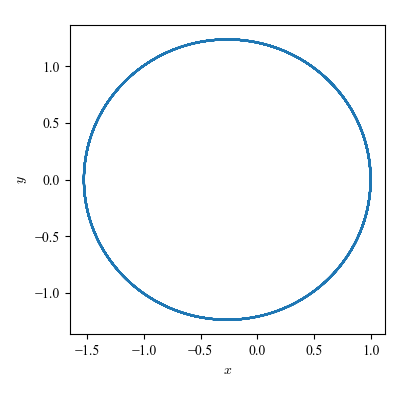

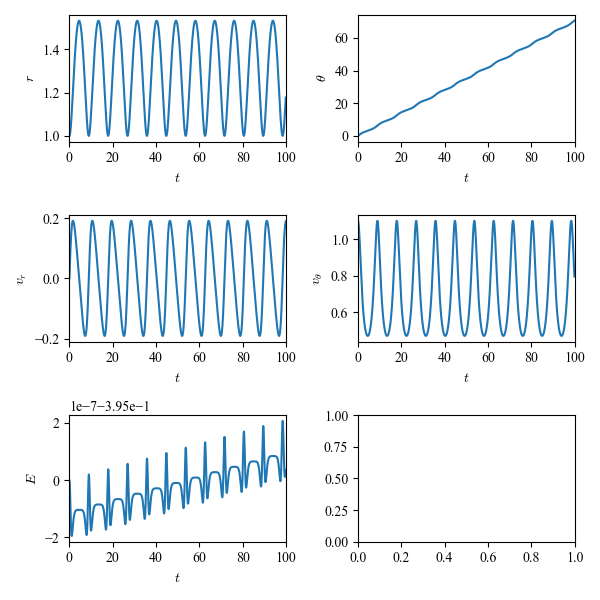

In [5]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'cm'

t = np.arange(0, _[T], _[h])

fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.plot(_['x'], _['y'])
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal')

fig, axes = plt.subplots(3, 2, figsize=(6, 6), tight_layout=True)
variables = [r, theta, v_r, v_theta, 'E']
for ax, var in zip(axes.flatten(), variables):
    name = getattr(var, 'name', var)
    ax.plot(t, _[var][:-1])
    ax.set_xlabel('$t$')
    ax.set_ylabel(f'${name}$')
    ax.set_xlim(0, _[T])
